# Project 3: Movie Connections
### Aron Cottman and Michael Lam

In [1]:
from google.colab import drive
drive.mount('/content/drive')


ModuleNotFoundError: No module named 'google.colab'

In [2]:
import os
path = '/content/drive/My Drive/Colab_Notebooks/CDS411/Project_3'
# if you need your own path to the project folder, just put it here.
# path = ''
os.chdir(path)
os.getcwd()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Colab_Notebooks/CDS411/Project_3'

In [3]:
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bacon, floyd
import movies3 as mov

In [4]:
# Get Data
f1 = "movies1000.xlsx"
movies, actors, isin = mov.ReadData(f1)

Our approach is to modify the G matrix so that the entries into the matrix are movie mids, and the values are the number of actor links to go from one move to another. 

Try making the Gmatrix from the set of mids from movies so that every movie is represented.  


In [5]:
def MakeG():
  ## list of unique mids + sort
  mids = np.array(list(set(movies[:,0])))
  N = len(mids)
  G = np.zeros((N+1,N+1))
  print(len(mids))
 # for each movie:
  for i in mids:
    ## get mids
    aids = mov.AidsFromMid(isin, i)
    ## aids from actor's movies
    mids2 = MidsFromAids( isin, aids )
    # populate G
    for a in mids2:
      G[i-1, a-1] = 1
    ## return G
  print("shape=",G.shape)
  return G
  
def MidsFromAids( isin, aids ):
  mids = []
  for i in aids:
    ndx = (isin[:,2]==i).nonzero()[0]
    mids.extend(isin[ndx,1])
  return mids


In [6]:
G = MakeG()
G,P = bacon.RunFloyd(G)

1000
shape= (1001, 1001)
0 

50 

100 

150 

200 

250 

300 

350 

400 

450 

500 

550 

600 

650 

700 

750 

800 

850 

900 

950 

1000 

In [7]:
#Validation 
mid1 = mov.MidFromTitle(movies, 'The Great Debaters' )
mid2 = mov.MidFromTitle(movies, "Adam’s Apples" )
v,h = mid1-1, mid2-1
path = floyd.FindPath(P,v,h)
mids = [i+1 for i in path]
mov.TitlesFromMids(movies, mids)

['The Great Debaters',
 'Remember the Titans',
 'The Spitfire Grill',
 'Space Cowboys',
 'No Country for Old Men',
 "The Hitchhiker's Guide to the Galaxy",
 'Harry Potter and the Chamber of Secrets',
 'Wilbur Wants to Kill Himself',
 'Adam’s Apples']

In [8]:
# get the number of connections for each movie without the extreme values.
g1_help = G < 100000 
g1_help = g1_help*G

In [9]:
# movie years
S = set(movies[:,2])

In [10]:
#create a df to work with.
df = pd.DataFrame(movies, columns = ['mid','title','year','rating'])

In [11]:
#This function calulatess the average chain length for a given mid.
# if the movie is not connected to any other movie, then 0
def acl(mid):
  idx = mid-1
  y = g1_help[idx,:]
  d = sum(y>0)
  if d == 0:
    x = 0
  else:
    x = sum(y)/sum(y>0)
  return (x)

In [12]:
# create a list of the average Chain Length
# the idx of the list is the mid-1.
aclList = []
for i in range(1,1001):
  a = acl(i)
  aclList.append(a)

In [13]:
#add the ACL to the df.
df['acl'] = aclList
df.head()

,mid,title,year,rating,acl
0,1,A Face in the Crowd,1957,8.2,3.683575
1,2,A Perfect Couple,1979,6,3.004831
2,3,Touch of Evil,1958,8,3.195652
3,4,Across the Universe,2007,7.4,0.000000
4,5,Amadeus,1983,8.3,3.169082


In [56]:
grouped = df.groupby('year')
YACL = grouped['acl'].mean()
Ymeans = [YACL[y] for y in YACL.keys()][9:]
Years = YACL.keys()[9:]

Int64Index([1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945,
            1946, 1947, 1948, 1949, 1950, 1951, 1953, 1954, 1955, 1956, 1957,
            1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
            1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
            1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
            1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
            2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
            2013, 2014, 2015, 2016, 2017, 2018, 2019],
           dtype='int64', name='year')

(1933.0, 2020.0)

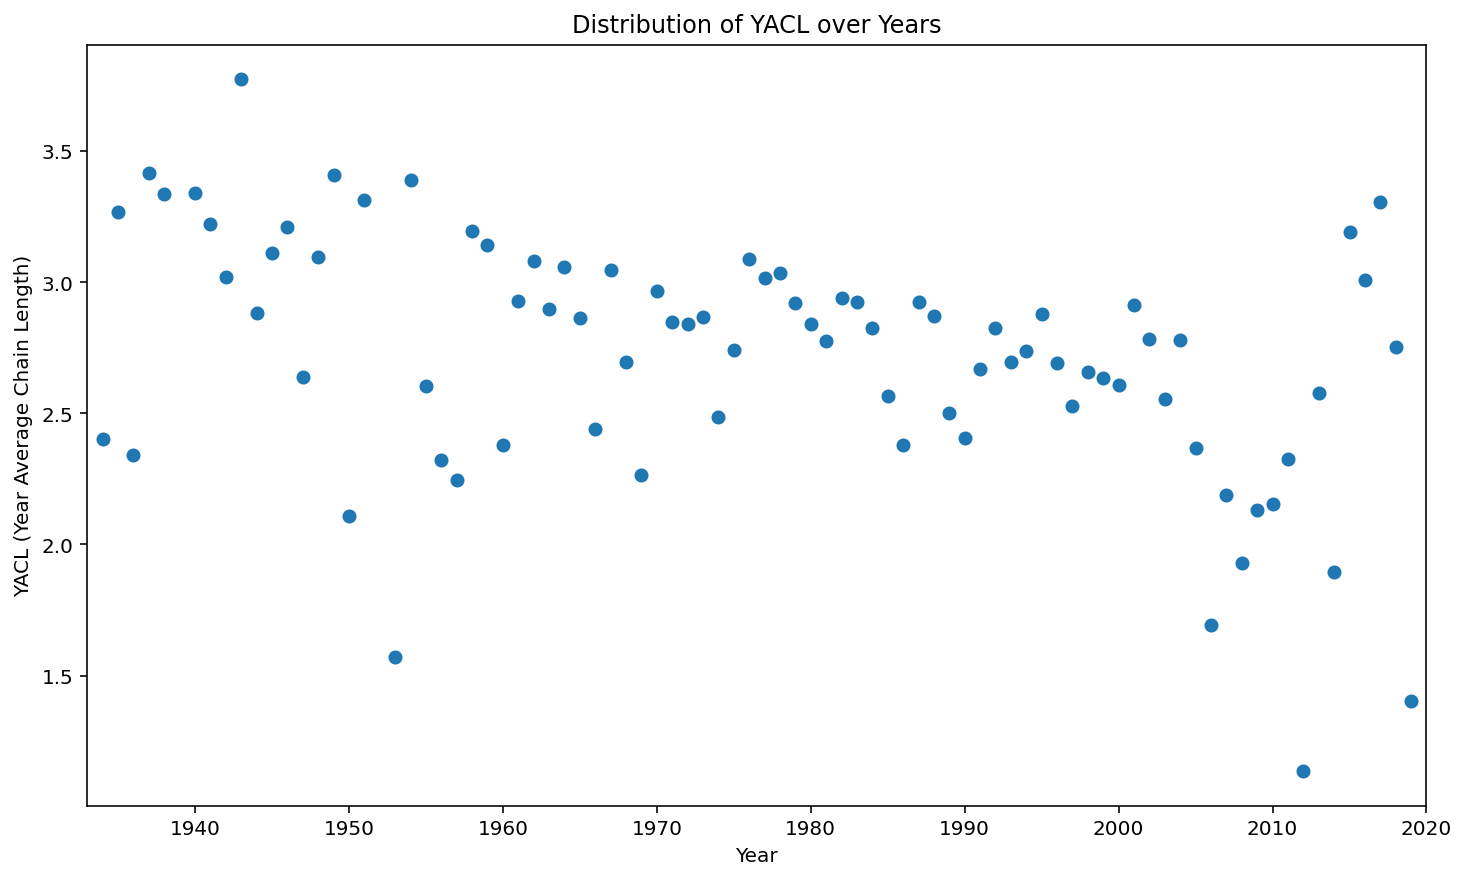

In [45]:
# fit a linear model to YACL predicted by year, and run a significance test.
plt.scatter(Years, Ymeans, label ='o')
plt.title('Distribution of YACL over Years'); plt.xlabel('Year'); plt.ylabel('YACL (Year Average Chain Length)')
plt.xlim([1933, 2020])

(1933.0, 2020.0)

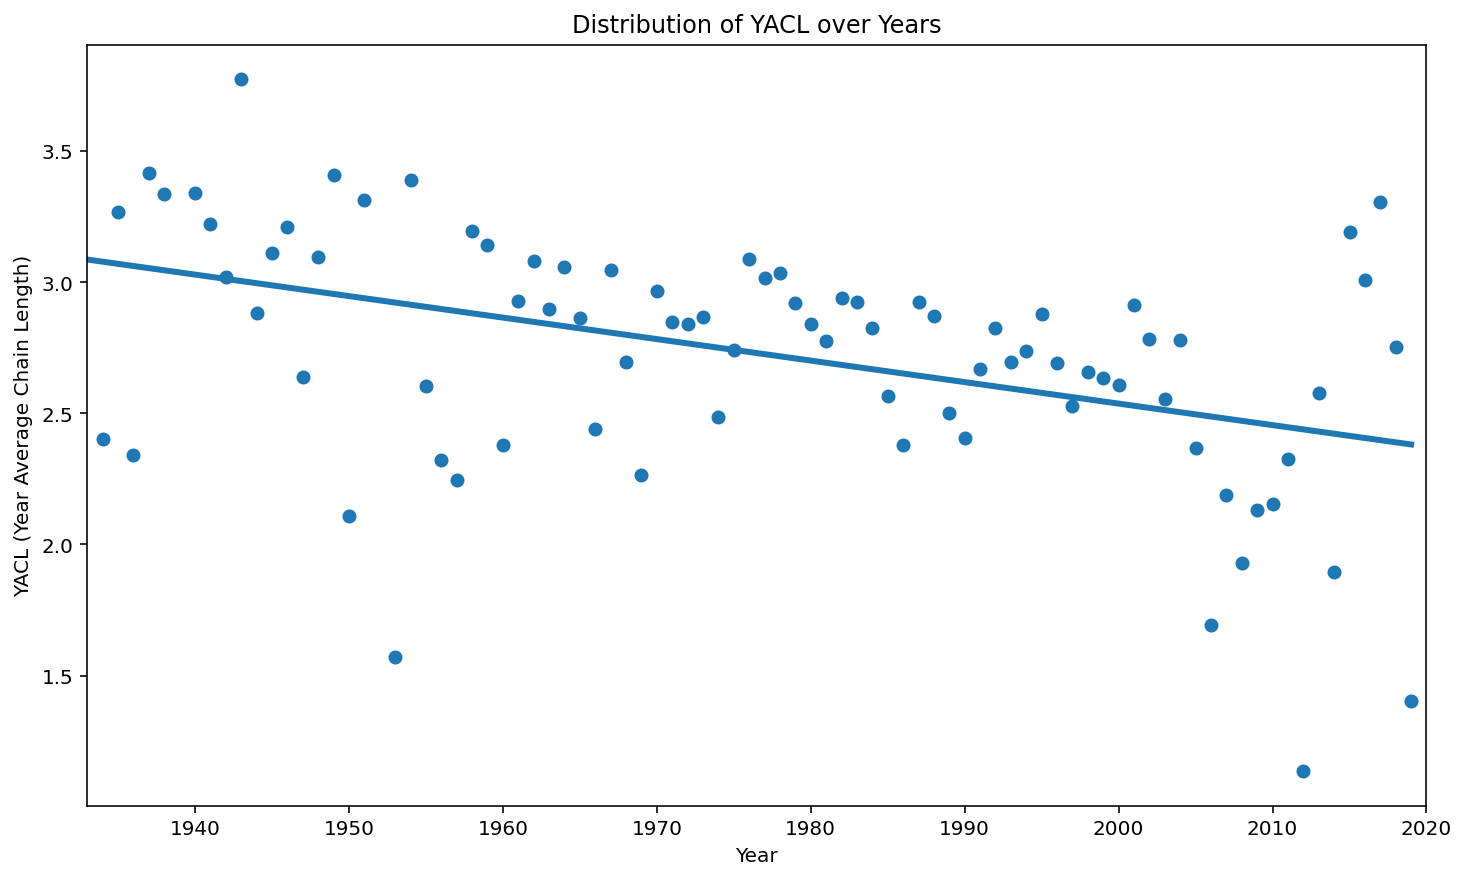

In [44]:
#scatterplot of YACL vs year,
plt.scatter(Years, Ymeans, label ='o')
plt.title('Distribution of YACL over Years'); plt.xlabel('Year'); plt.ylabel('YACL (Year Average Chain Length)')
m,b = np.polyfit(Years, Ymeans, 1)
plt.plot(YACL.keys(), m*YACL.keys()+b, linewidth=3.0)
plt.xlim([1933, 2020])

In [47]:
r = np.corrcoef(Years, Ymeans)
r

array([[ 1.        , -0.43491621],
       [-0.43491621,  1.        ]])

In [49]:
# ttest
tscore, p = ttest_ind(Years, Ymeans)
print('T-Score = %.3f, p = %.3f' % (tscore, p))
# interpretion
alpha = 0.05
if p > alpha:
  print('Fail to reject H0')
else:
  print('Reject H0')

T-Score = 730.315, p = 0.000
Reject H0


In [19]:
# check the relationship of the connectivity between movies in a year
# i would guess its related to the number of movies from that year in the data
# therefore, plot the number of movies for each year against the YACL.
# maybe even fit a multivariate model that uses number of movies in a year
# and the year to prediuct YACL.

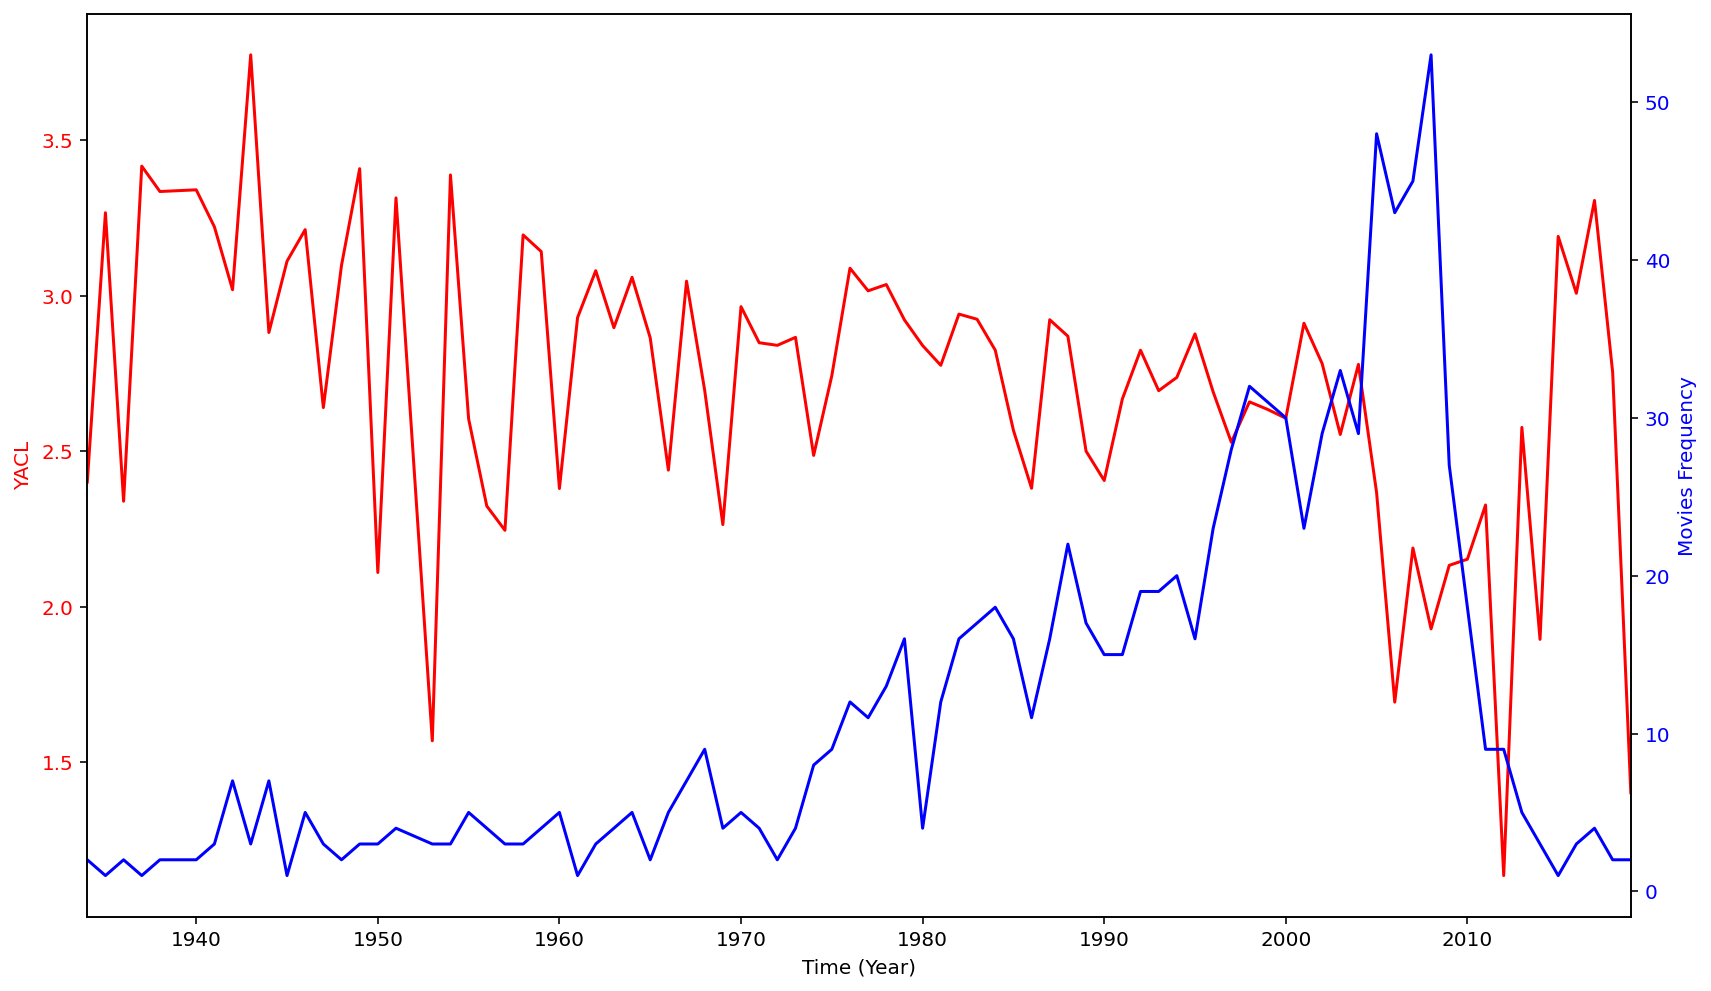

In [57]:
year_freq = df['year'].value_counts().sort_index()
Ycount = [year_freq[y] for y in Years]

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax1.set_xlabel('Time (Year)')
ax1.set_ylabel('YACL', color='red')
ax1.plot(Years, Ymeans, color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xlim([1935,2019])
ax2.set_ylabel('Movies Frequency', color='blue')  # we already handled the x-label with ax1
ax2.plot(Years, Ycount, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_xlim([1934,2019])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()